In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mne
from sklearn.cluster import KMeans, SpectralClustering, DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

%matplotlib qt


# Import Raw

In [3]:
# global
SEED = 73
np.random.seed(seed=SEED)
RESAMPLE_FREQ = 256
DS_DIR = "../mi_ds/"
EDF_DIR = "edf/"

BAD_SUBS = [5, 6, 15, 22, 24, 25]

sub = 1
ses = 2
_file = f"sub-{sub:03d}_ses-{ses:02d}_task_motorimagery_eeg.edf"
raw = mne.io.read_raw_edf(f"{DS_DIR}{EDF_DIR}{_file}", preload=True)
raw.set_montage("standard_1020")



Extracting EDF parameters from /home/cardoso/phd/motor_imagery/mi_ds/edf/sub-001_ses-02_task_motorimagery_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 99999  =      0.000 ...   399.996 secs...


<RawEDF | sub-001_ses-02_task_motorimagery_eeg.edf, 32 x 100000 (400.0 s), ~24.5 MB, data loaded>

## Compare filter and raw 

In [4]:
DIR = f"{DS_DIR}/events/"
file = f"sub-0{sub:02d}_ses-{ses:02d}_task_motorimagery_events.tsv"
events = np.loadtxt(f"{DIR}{file}", delimiter='\t', dtype='object',
                    skiprows=1)

In [5]:
events = events[:, [0, 1, -1]]
events[:, 0] = np.array([int(float(num.strip())) for num in events[:, 0]])
events[:, 1] = np.array([0 for _ in events[:, 1]])
events[:, -1] = np.array([int(float(num.strip())) for num in events[:, -1]])
events = events.astype(np.int32)
events[:, 0] -= 1


In [6]:
event_id = {"left": 1, "right": 2}
epochs = mne.Epochs(raw, tmin=0.0, tmax=3.99, events=events, event_id=event_id,
                    baseline=None, preload=True)
epochs_filt = epochs.copy()

Not setting metadata
100 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 100 events and 999 original time points ...
0 bad epochs dropped


In [18]:
data = epochs.get_data(copy=True)

In [19]:
data.shape

(100, 32, 999)

In [20]:
raw_dat = raw.get_data()

In [21]:
data = np.concatenate(data, axis=1)

In [22]:
data.shape, raw_dat.shape

((32, 99900), (32, 100000))

In [25]:
data[23, -10:], raw_dat[23, -10:]

(array([-2.14770977e-06, -2.46202948e-06, -2.89899072e-06, -3.20153359e-06,
        -3.65616009e-06, -3.52032037e-06, -3.34366782e-06, -3.72824245e-06,
        -3.44052215e-06, -3.43930386e-06]),
 array([-2.46202948e-06, -2.89899072e-06, -3.20153359e-06, -3.65616009e-06,
        -3.52032037e-06, -3.34366782e-06, -3.72824245e-06, -3.44052215e-06,
        -3.43930386e-06, -4.18002626e-06]))

In [6]:
epochs_filt.filter(l_freq=1, h_freq=40, pad='reflect_limited', verbose=True)

Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 3041 tasks      | elapsed:    0.6s


<Epochs | 100 events (all good), 0 – 3.992 s (baseline off), ~24.4 MB, data loaded,
 'left': 50
 'right': 50>

In [7]:
data_filtered = np.concatenate(epochs_filt.get_data(copy=True), axis=1)
data_filtered.shape, raw.get_data().shape

((32, 99900), (32, 100000))

In [8]:
raw_filt = mne.io.RawArray(data_filtered, raw.info)

Creating RawArray with float64 data, n_channels=32, n_times=99900
    Range : 0 ... 99899 =      0.000 ...   399.596 secs
Ready.


## apply ICA on previously filtered data

In [9]:
ica = mne.preprocessing.ICA(n_components=32, random_state=SEED)
ica.fit(raw_filt)

Fitting ICA to data using 32 channels (please be patient, this may take a while)


/tmp/ipykernel_2528548/292496746.py:2: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_filt)


Selecting by number: 32 components
Fitting ICA took 7.4s.


Method,fastica
Fit parameters,algorithm=parallelfun=logcoshfun_args=Nonemax_iter=1000
Fit,46 iterations on raw data (99900 samples)
ICA components,32
Available PCA components,32
Channel types,eeg
ICA components marked for exclusion,—


In [10]:
eog_indices, eog_scores = ica.find_bads_eog(raw, ch_name=['Fp1', 'Fp2'])

Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2500 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2500 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2500 sam

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


[1, 3]


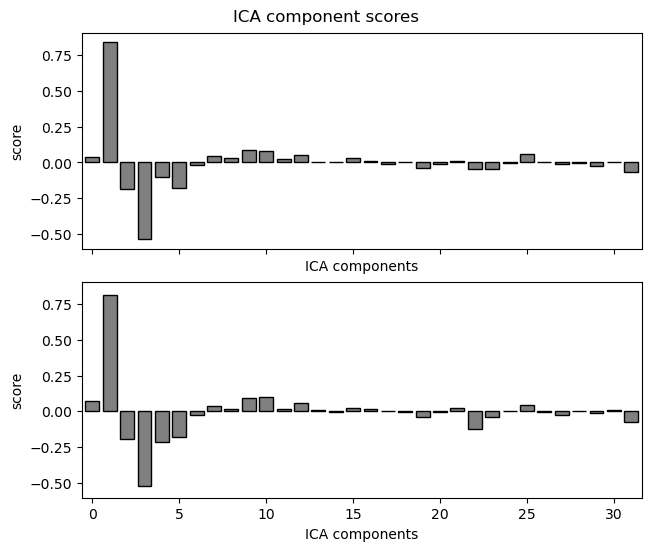

In [11]:
print(eog_indices)
ica.plot_scores(eog_scores)

In [12]:
print(ica.get_explained_variance_ratio(raw))
print(eog_scores[0].shape)

{'eeg': 1.0}
(32,)


In [13]:
CLUSTER = True
if CLUSTER:
    _shape = (eog_scores[0].shape[0], 2)
    _eog_scores = np.zeros(_shape)
    for i in range(2):
        _eog_scores[:, i] = np.abs(eog_scores[i])

    # get dist to origin
    _dist = np.linalg.norm(_eog_scores, axis=1)

    clstr = SpectralClustering(n_clusters=2, random_state=SEED,
                            assign_labels='discretize')
    clstr.fit(np.reshape(_dist, (-1, 1)))

    mask = clstr.labels_ == 0
    avg_0 = np.mean(_dist[mask])
    avg_1 = np.mean(_dist[~mask])

    exclude = 0 if avg_0 > avg_1 else 1
    ica.exclude = np.nonzero(clstr.labels_ == exclude)[0]


    fig, ax = plt.subplots()
    ax.plot(_eog_scores[clstr.labels_ == 0, 0], _eog_scores[clstr.labels_ == 0, 1], 'b*')
    ax.plot(_eog_scores[clstr.labels_ == 1, 0], _eog_scores[clstr.labels_ == 1, 1], 'r*')
else:
    ica.exclude = eog_indices



In [14]:
# reconstruct raw data with excluded components
raw_corrected = raw.copy()
ica.apply(raw_corrected)

Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 2 ICA components
    Projecting back using 32 PCA components


<RawEDF | sub-001_ses-02_task_motorimagery_eeg.edf, 32 x 100000 (400.0 s), ~24.5 MB, data loaded>

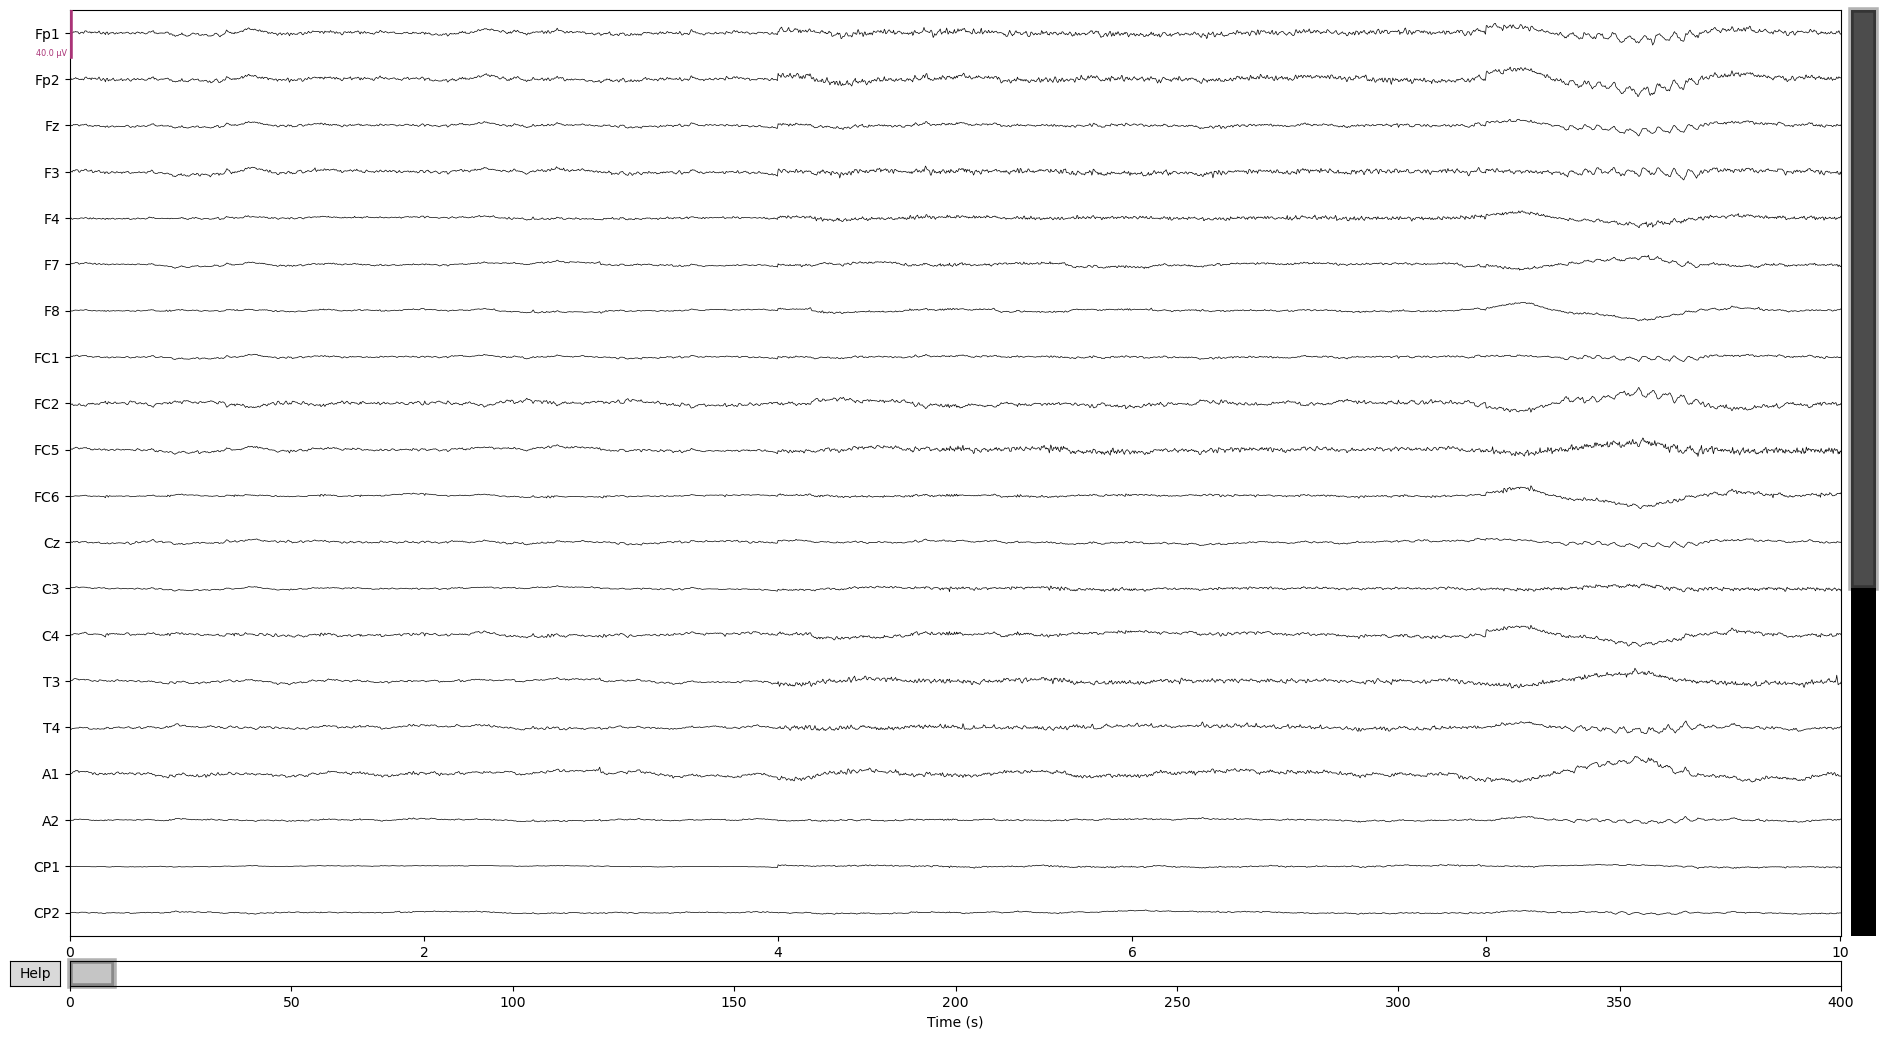

Channels marked as bad:
none
Channels marked as bad:
none


In [16]:
raw.plot()
raw_corrected.plot()

In [17]:
epochs = mne.Epochs(raw_corrected, tmin=0.0, tmax=3.99, events=events,
                    event_id=event_id, baseline=None, preload=True)

Not setting metadata
100 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 100 events and 999 original time points ...
0 bad epochs dropped


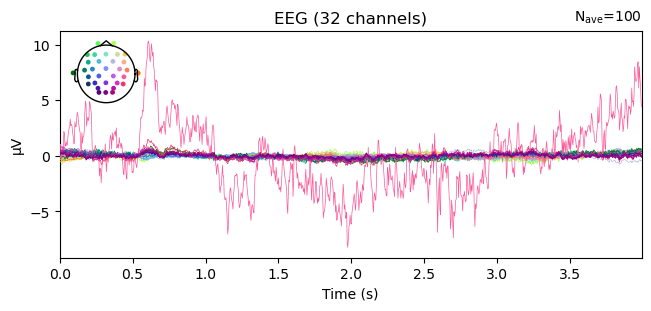

In [18]:
epochs.average().plot()

In [19]:
epochs = epochs.filter(l_freq=1, h_freq=40, pad='reflect_limited', verbose=True)

Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 3041 tasks      | elapsed:    0.5s


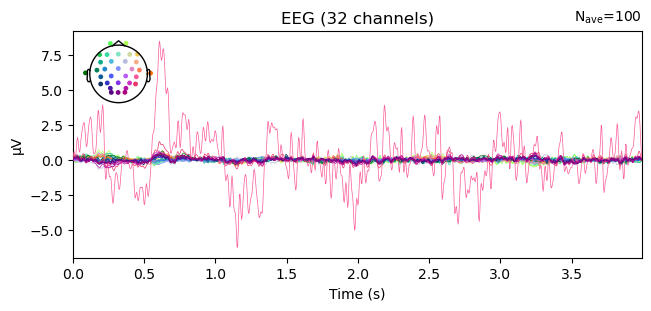

In [20]:
epochs.average().plot()

In [21]:
# find max amplitude in each epoch and channel
epochs_backup = epochs.copy()
new_epochs = []
for epoch_idx, epoch in enumerate(epochs_backup):
    bad_channs = []
    max_amps = np.max(np.abs(epoch), axis=1)
    mask = max_amps > 100e-6

    # find bad channels
    if np.any(mask):
        print(f"Epoch {epoch_idx} has bad channels")
    idx = list(np.argwhere(mask).astype(np.int32).flatten())

    # append to list of bad channels
    for i in idx:
        _chann = epochs.ch_names[i]
        print(f"channel {i} ({_chann}) has max amplitude {max_amps[i]}")
        bad_channs.append(epochs.ch_names[i])
    
    # interpolate bad channels
    current_epoch = epochs_backup[epoch_idx]
    if len(bad_channs) > 0:
        current_epoch.info['bads'] = bad_channs
        print(f"epoch {epoch_idx} has {current_epoch.info['bads']} bad channels")
        current_epoch.interpolate_bads(reset_bads=True)
    new_epochs.append(current_epoch) 
    del bad_channs

Epoch 61 has bad channels
channel 21 (CP6) has max amplitude 0.0001151416454398256
epoch 61 has ['CP6'] bad channels
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 94.8 mm
Computing interpolation matrix from 31 sensor positions
Interpolating 1 sensors
Epoch 71 has bad channels
channel 21 (CP6) has max amplitude 0.00010052145552798947
epoch 71 has ['CP6'] bad channels
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 94.8 mm
Computing interpolation matrix from 31 sensor positions
Interpolating 1 sensors
Epoch 73 has bad channels
channel 21 (CP6) has max amplitude 0.00011320546887401824
epoch 73 has ['CP6'] bad channels
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 94.8 mm
Computing interpolation matrix from 31 sensor positions
Interpolating 1 sensors

In [22]:
new_epochs = mne.concatenate_epochs(new_epochs)

Not setting metadata
100 matching events found
No baseline correction applied


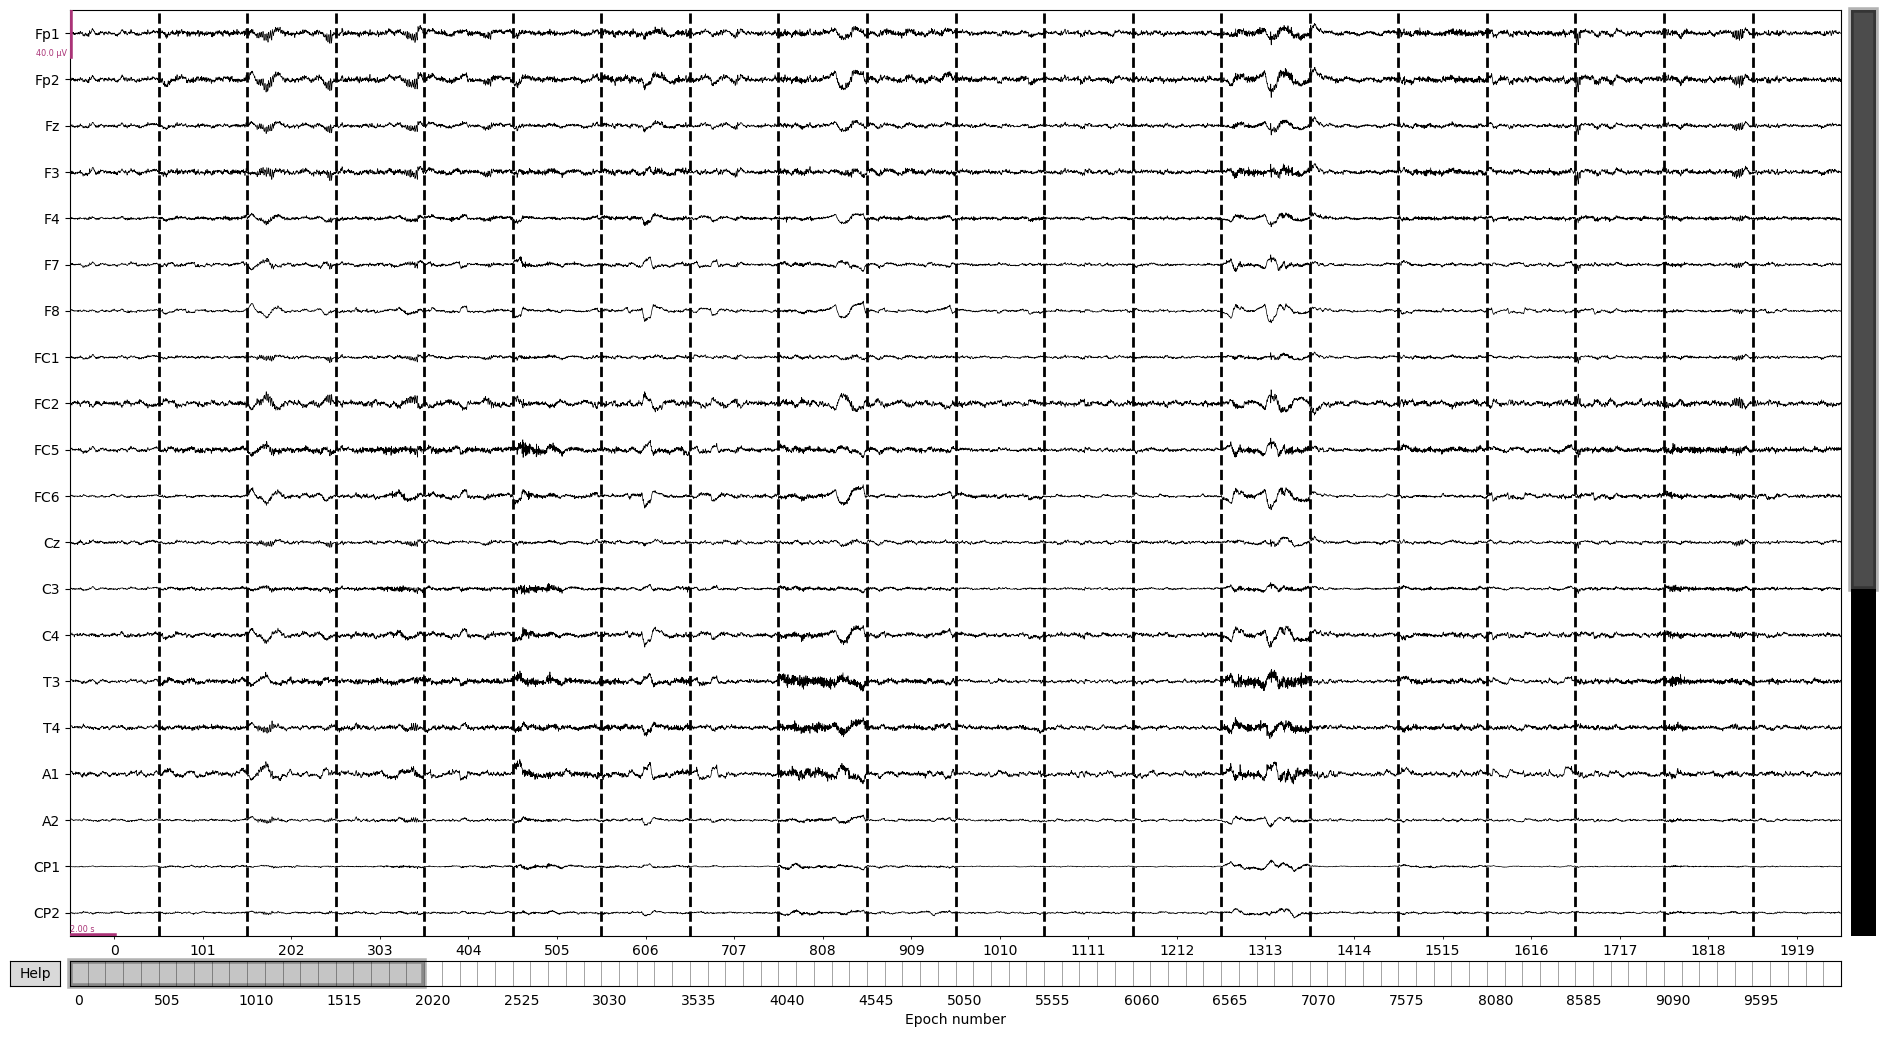

Dropped 0 epochs: 
The following epochs were marked as bad and are dropped:
[]
Channels marked as bad:
none
Dropped 0 epochs: 
The following epochs were marked as bad and are dropped:
[]
Channels marked as bad:
none


In [23]:
epochs.plot()
new_epochs.plot()

In [ ]:
new_epochs.get_data().shape, epochs.get_data().shape

In [1]:
new_epochs.plot()
epochs.plot()

NameError: name 'new_epochs' is not defined

In [ ]:
new_epochs.average().plot()
epochs.average().plot()

In [ ]:
new_epochs['right'].average().plot_joint()
new_epochs['left'].average().plot_joint()

In [ ]:
epochs.plot()

In [ ]:
new_epochs.plot()

In [ ]:
raw.plot()